<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Посмотрим-на-данные" data-toc-modified-id="Посмотрим-на-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Посмотрим на данные</a></span></li><li><span><a href="#Обучим-сетку" data-toc-modified-id="Обучим-сетку-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучим сетку</a></span></li></ul></div>

## Посмотрим на данные

датасет доступен и описан на https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/dota2Train.csv', names=['label', 'cluster', 'mode', 'type', *['hero_'+ str(i-4) for i in range(4, 117)]])
print(df.shape)
df.head()

(92650, 117)


,label,cluster,mode,type,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,...,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df.drop(columns = ['label'])
for col in X.columns:
    if X[col].std():
        X[col] = (X[col] - X[col].mean())/X[col].std()
    else:
        X[col] = 0
y = df.label.values

X.head()
y[y == -1] = 0

Проверим баланс классов

In [4]:
print(y[y ==1].size / y.size)
X.shape

0.5265191581219644


(92650, 116)

/home/anton/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


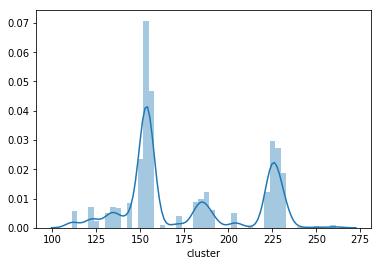

In [5]:
sns.distplot(df.cluster)

## Обучим сетку

In [6]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 500)
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 1)
       # self.tr = nn.Threshold(0.5, 0)

    def forward(self, x):
        x = x.view(-1, X.shape[1])
        x = torch.tanh(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x


net = Net()
net = net.to(device)
print(net)

Net(
  (fc1): Linear(in_features=116, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=X.cluster)
print(y_test[y_test == 0].size / y_test.size)
X_tr_t = torch.from_numpy(X_train.values).float().to(device)
X_ts_t = torch.from_numpy(X_test.values).float().to(device)
y_tr_t = torch.from_numpy(y_train).float().to(device)
y_ts_t = torch.from_numpy(y_test).float().to(device)

0.47299572594223543


проверяем что сеть работает

In [10]:
inp = X_ts_t
inp.size()
output = net(inp).view(-1, y_test.size)[0]

criterion = nn.BCELoss()
print(y_test)
print(output.cpu().detach().numpy())
loss = criterion(output, y_ts_t)
predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
predict[predict > 0] = 1
print(predict)
print(loss.item())
print(accuracy_score(y_test, predict))

[1 1 1 ... 0 1 1]
[0.52289593 0.50215214 0.5161197  ... 0.52143687 0.51240784 0.5092067 ]
[1. 1. 1. ... 1. 1. 1.]
0.6924043297767639
0.5236368346069162


учим

In [11]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.ASGD(net.parameters(), lr=0.001)

In [12]:
K = 50
x = np.arange(1, 201)
acc_train = []
acc_test =[]

for epoch in x:
    
    running_loss = 0.0
    for i in range(0, X_train.shape[0], K):
        # get the inputs
        end = min(i + K, X_train.shape[0])
        inputs = X_tr_t[i: end]
        labels = y_tr_t[i: end]
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #print((i, end))
        outputs = net(inputs).view(-1, end - i)[0]
       # print(inputs)
        #print(outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    # print every epoch
    inp = X_tr_t
    output = net(inp).view(-1, y_train.size)[0]
    predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
    predict[predict > 0] = 1
    acc_tr = accuracy_score(y_train, predict)
    
    inp = X_ts_t
    output = net(inp).view(-1, y_test.size)[0]
    predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
    predict[predict > 0] = 1
    acc_ts = accuracy_score(y_test, predict)
    if(epoch % 10  == 0):
        print('%d loss: %.3f acc_train: %.2f%% acc_test: %.2f%%' %
            (epoch, running_loss, acc_tr*100, acc_ts*100))
    acc_train.append(acc_tr)
    acc_test.append(acc_ts)
    running_loss = 0.0

1 loss: 961.831 acc_train: 52.70% acc_test: 52.79%
2 loss: 961.058 acc_train: 52.66% acc_test: 52.76%
3 loss: 960.500 acc_train: 52.66% acc_test: 52.76%
4 loss: 959.993 acc_train: 52.67% acc_test: 52.73%
5 loss: 959.483 acc_train: 52.67% acc_test: 52.75%
6 loss: 958.947 acc_train: 52.68% acc_test: 52.77%
7 loss: 958.374 acc_train: 52.76% acc_test: 52.82%
8 loss: 957.751 acc_train: 52.79% acc_test: 52.86%
9 loss: 957.067 acc_train: 52.93% acc_test: 53.04%
10 loss: 956.309 acc_train: 53.09% acc_test: 53.16%
11 loss: 955.466 acc_train: 53.38% acc_test: 53.43%
12 loss: 954.522 acc_train: 53.80% acc_test: 53.86%
13 loss: 953.462 acc_train: 54.33% acc_test: 54.18%
14 loss: 952.270 acc_train: 54.95% acc_test: 54.70%
15 loss: 950.926 acc_train: 55.62% acc_test: 55.27%
16 loss: 949.418 acc_train: 56.34% acc_test: 55.93%
17 loss: 947.734 acc_train: 56.93% acc_test: 56.31%
18 loss: 945.867 acc_train: 57.48% acc_test: 56.88%
19 loss: 943.823 acc_train: 58.00% acc_test: 57.33%
20 loss: 941.611 acc_

158 loss: 856.645 acc_train: 66.66% acc_test: 58.18%
159 loss: 855.432 acc_train: 66.77% acc_test: 58.17%
160 loss: 854.203 acc_train: 66.85% acc_test: 58.19%
161 loss: 852.956 acc_train: 66.94% acc_test: 58.14%
162 loss: 851.693 acc_train: 67.03% acc_test: 58.08%
163 loss: 850.416 acc_train: 67.13% acc_test: 58.08%
164 loss: 849.122 acc_train: 67.21% acc_test: 58.03%
165 loss: 847.814 acc_train: 67.28% acc_test: 57.96%
166 loss: 846.491 acc_train: 67.40% acc_test: 57.91%
167 loss: 845.152 acc_train: 67.49% acc_test: 57.84%
168 loss: 843.794 acc_train: 67.58% acc_test: 57.77%
169 loss: 842.419 acc_train: 67.70% acc_test: 57.76%
170 loss: 841.028 acc_train: 67.79% acc_test: 57.78%
171 loss: 839.620 acc_train: 67.91% acc_test: 57.72%
172 loss: 838.198 acc_train: 68.00% acc_test: 57.66%
173 loss: 836.763 acc_train: 68.09% acc_test: 57.64%
174 loss: 835.305 acc_train: 68.22% acc_test: 57.64%
175 loss: 833.831 acc_train: 68.29% acc_test: 57.64%
176 loss: 832.340 acc_train: 68.37% acc_test: 

In [13]:
inp = X_ts_t
inp.size()
output = net(inp).view(-1, y_test.size)[0]

criterion = nn.BCELoss()
#print(y_test)
#print(output.cpu().detach().numpy())
loss = criterion(output, y_ts_t)
predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
predict[predict > 0] = 1
#print(predict)
print(loss.item())
print(accuracy_score(y_test, predict))

0.7222638130187988
0.565902516945128


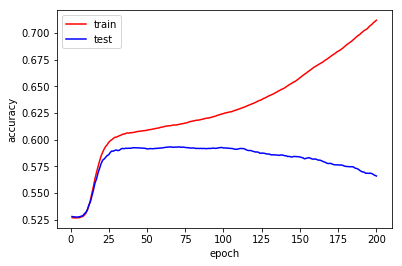

In [22]:
tr, = plt.plot(x, acc_train, c='r', label ='train')
ts, = plt.plot(x, acc_test, c='b', label = 'test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(handles=[tr, ts])
plt.show()

повторим то же с высоким лернинг рейтом

In [25]:
net = Net()
net = net.to(device)
optimizer = optim.ASGD(net.parameters(), lr=0.01)

K = 50
x = np.arange(1, 50)
acc_train = []
acc_test =[]

for epoch in x:
    
    running_loss = 0.0
    for i in range(0, X_train.shape[0], K):
        # get the inputs
        end = min(i + K, X_train.shape[0])
        inputs = X_tr_t[i: end]
        labels = y_tr_t[i: end]
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #print((i, end))
        outputs = net(inputs).view(-1, end - i)[0]
       # print(inputs)
        #print(outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    # print every epoch
    inp = X_tr_t
    output = net(inp).view(-1, y_train.size)[0]
    predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
    predict[predict > 0] = 1
    acc_tr = accuracy_score(y_train, predict)
    
    inp = X_ts_t
    output = net(inp).view(-1, y_test.size)[0]
    predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
    predict[predict > 0] = 1
    acc_ts = accuracy_score(y_test, predict)
    if(epoch % 10  == 0):
        print('%d loss: %.3f acc_train: %.2f%% acc_test: %.2f%%' %
            (epoch, running_loss, acc_tr*100, acc_ts*100))
    acc_train.append(acc_tr)
    acc_test.append(acc_ts)
    running_loss = 0.0

10 loss: 906.708 acc_train: 62.02% acc_test: 59.43%
20 loss: 861.432 acc_train: 66.83% acc_test: 57.58%
30 loss: 790.126 acc_train: 71.90% acc_test: 55.90%
40 loss: 679.446 acc_train: 77.14% acc_test: 54.79%


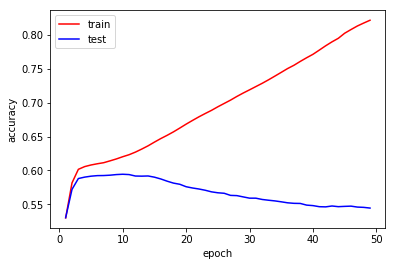

In [26]:
tr, = plt.plot(x, acc_train, c='r', label ='train')
ts, = plt.plot(x, acc_test, c='b', label = 'test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(handles=[tr, ts])
plt.show()

Добавим шума

In [34]:
X_tr_t = torch.from_numpy(X_train.values + np.random.normal(0, 1,X_train.values.shape)).float().to(device)

In [35]:
net = Net()
net = net.to(device)
optimizer = optim.ASGD(net.parameters(), lr=0.01)

K = 50
x = np.arange(1, 50)
acc_train = []
acc_test =[]

for epoch in x:
    
    running_loss = 0.0
    for i in range(0, X_train.shape[0], K):
        # get the inputs
        end = min(i + K, X_train.shape[0])
        inputs = X_tr_t[i: end]
        labels = y_tr_t[i: end]
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #print((i, end))
        outputs = net(inputs).view(-1, end - i)[0]
       # print(inputs)
        #print(outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    # print every epoch
    inp = X_tr_t
    output = net(inp).view(-1, y_train.size)[0]
    predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
    predict[predict > 0] = 1
    acc_tr = accuracy_score(y_train, predict)
    
    inp = X_ts_t
    output = net(inp).view(-1, y_test.size)[0]
    predict = torch.nn.functional.threshold(output, 0.5, 0).cpu().detach().numpy()
    predict[predict > 0] = 1
    acc_ts = accuracy_score(y_test, predict)
    if(epoch % 10  == 0):
        print('%d loss: %.3f acc_train: %.2f%% acc_test: %.2f%%' %
            (epoch, running_loss, acc_tr*100, acc_ts*100))
    acc_train.append(acc_tr)
    acc_test.append(acc_ts)
    running_loss = 0.0

10 loss: 925.219 acc_train: 60.29% acc_test: 58.99%
20 loss: 851.058 acc_train: 68.45% acc_test: 55.39%
30 loss: 690.069 acc_train: 76.65% acc_test: 53.62%
40 loss: 384.602 acc_train: 83.86% acc_test: 53.49%


In [ ]:
tr, = plt.plot(x, acc_train, c='r', label ='train')
ts, = plt.plot(x, acc_test, c='b', label = 'test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(handles=[tr, ts])
plt.show()